# Run `Background` for multiple targets

In [1]:
import os
import sys
import shutil
import numpy as np
import pandas as pd

In [23]:
from astropy import units as u
from astropy import constants as const
from astropy.table import Table, unique, join

In [3]:
import glob
import subprocess

In [4]:
sys.path.insert(0, "./results/python")
import background as bg

In [5]:
from matplotlib import pyplot as plt

In [6]:
# Set-up names and which background model to fit
# Define model
model_name = 'OneHarvey'

# Is there a prefix to your star IDs?
prefix = 'CRT0'

# What is the number of the run you want to initiate?
resultsubdir = '51'

# What is the name of the projects directory?
idstr = 'corot'

In [7]:
# Do you want to estimate the numax from a logg and teff?
estimatenumax = True
# Name the table containing spectroscopic values used to estimate numax
spectrotable = 'Corot_table_final2_allstars.csv'
# What is the fillvalue in spectrotable?
fillvalue = -999
# Name the colulm in spectrotable containing star ID
staridcol = 'corot_id'
# Name the columns containing logg
loggcols = ['logg_photo_2M', 'logg_photo_0.9M']
# Name the flag columns for loggcols in same order
flagcols = ['flag_logg_2M', 'flag_logg_09M']
# Name the column containing the effective temperature
teffcol = 'teff'
# Name the limits within estimated numax should be used
hlimit = 120
llimit = 2

# Do you want to truncate the datafiles?
truncatedatafiles = False

In [ ]:
numaxguessfiles = None
#numaxguessfiles = ['projects/corot/LRc01_PSD_No_LC_Yes.csv', 
#                   'projects/corot/LRc01_both.csv',
#                   'projects/corot/LRc01_PSD_Yes_LC_No.csv',
#                   'projects/corot/LCs_NoPSD_enero22.csv',]
mainnumaxdir = 'projects/corot/jan2022'

## Set up starlist and stars

In [8]:
# Use all the stars with a .txt file in `./data`
starlist = []
for star in os.listdir('./data/'):
    if star.endswith('.txt'):
        starlist.append(star[4:-4])

In [9]:
def estimate_numax(logg, teff):
    gsun = ((const.G * const.M_sun) / (const.R_sun) ** 2).to(u.cm / u.second ** 2).value
    loggsun = np.log10(gsun)
    teffsun = 5772  # Kelvin, Prsa et al. 2016
    numaxsun = 3090  # µHz, Huber et al 2011
    
    # Estimate numax from log g and teff
    numax = ((10 ** (logg - loggsun)) * (teff / teffsun) ** (-1/2) * numaxsun)
    return numax

In [12]:
if estimatenumax:
    # Estimate numax from teff and logg for each star only once
    # Return a table with ID and estimated numax
    dirp = os.path.join('projects', idstr)
    df = os.path.join(dirp, spectrotable)
    reftable = Table.read(df, format='csv')
    
    assert len(loggcols) == len(flagcols)
    
    # Check for unique values
    ureftable = unique(reftable, keys=[staridcol])
    print(f'Number of unique stars {len(ureftable)} out of {len(reftable)}')
    
    numax = np.ones(len(reftable[staridcol]), dtype=float) * float(fillvalue)
    origin = np.ones(len(reftable[staridcol]), dtype='int') * int(fillvalue)
    flags = np.ones(len(reftable[staridcol]), dtype='int') * int(fillvalue)
    for i, (loggcol, flagcol) in enumerate(zip(loggcols[::-1], flagcols[::-1])):
        print(loggcol, flagcol)
        mask = (reftable[loggcol].mask & reftable[teffcol].mask)
        enumax = estimate_numax(reftable[loggcol], reftable[teffcol])
        flag = (reftable[flagcol] == fillvalue)
        valid = ((enumax > llimit) & (enumax < hlimit) & (~mask) & (~flag))
        print(np.sum(valid))
        numax[valid] = enumax[valid]
        origin[valid] = np.ones(len(numax))[valid] * i
    
    reftable.add_column(numax, name='numax')
    reftable.add_column(origin, name='origin_estimatenumax')
    reftable.add_column(flags, name='flag_estimatenumax')
    numaxtable = reftable[staridcol, 'numax', 'origin_estimatenumax', 'flag_estimatenumax']

    # Handle non-unqiue entries
    us, cs = np.unique(reftable[staridcol][reftable['numax'] != fillvalue], return_counts=True)
    if any(cs > 1):
        print('Non-unique entries found')
        unumaxtable = unique(numaxtable, keys=[staridcol])
        nonuniques = us[cs > 1]

        # Overwrite if another nu has a better origin 
        for nu in nonuniques:
            numask = (numaxtable[staridcol] == nu) & (numaxtable['numax'] != fillvalue)
            nunumax = numaxtable['numax'][numask]
            nuorigin = numaxtable['origin_estimatenumax'][numask]
            nuflag = numaxtable['flag_estimatenumax'][numask]
            assert nunumax.shape == nuorigin.shape
            # Count how many
            best = (nuorigin == np.amax(nuorigin))
            idx = np.argwhere(unumaxtable[staridcol] == nu)[0][0]
            offset = 0

            # TODO: There is a weird error of many numax being close to 10.0??
            close = np.isclose(nunumax, 10.0)
            if any(close):
                print('nonnumax is close to 10')
                best &= ~close

            if np.sum(best) == 1:
                unumaxtable['numax'][idx] = nunumax[best]
                unumaxtable['origin_estimatenumax'][idx] = nuorigin[best]
            elif np.sum(best) > 1:
                unumaxtable['numax'][idx] = nunumax[best][0]
                unumaxtable['origin_estimatenumax'][idx] = nuorigin[best][0]
                unumaxtable['flag_estimatenumax'][idx] = 1
            else:
                offset += 1
                best = (nuorigin == (np.amax(nuorigin) - offset))
                for i, nonnumax in enumerate(nuorigin[best]):
                    if nonnumax == 10:
                        best[i] = False
                if np.sum(best) == 1:
                    unumaxtable['numax'][idx] = nunumax[best]
                    unumaxtable['origin_estimatenumax'][idx] = nuorigin[best]
                elif np.sum(best) > 1:
                    unumaxtable['numax'][idx] = nunumax[best][0]
                    unumaxtable['origin_estimatenumax'][idx] = nuorigin[best][0]
                    unumaxtable['flag_estimatenumax'][idx] = 1
                else:
                    print('No numax found for', nu)
                    unumaxtable.remove_row(idx)
                    assert nu not in unumaxtable[staridcol]
        numaxtable = unumaxtable

    #
    fillmask = (numaxtable['numax'] != fillvalue)
    # Save file in numaxdir
    numaxdir = os.path.join(dirp,'estimatenumax/')
    numaxtable[fillmask].write(
        os.path.join(numaxdir, 'reftable' + resultsubdir + '.txt'),
        format='csv', delimiter='\t', overwrite=True)
else:
    # Read in list of initial guesses of numax from manual inspection
    numaxdirs = [d for d in os.listdir(mainnumaxdir)
                 if os.path.isdir(os.path.join(mainnumaxdir, d))]
    print(numaxdirs)
    psd = True
    # resultsubdir = 11 for PSD
    # resultsubdir = 21 for LC

    if psd:
        numaxdir = os.path.join(mainnumaxdir, numaxdirs[0])
        print(numaxdirxdir)
    else:
        numaxdir = os.path.join(mainnumaxdir, numaxdirs[1])
        print(numaxdir)

Number of unique stars 163580 out of 176802
logg_photo_0.9M flag_logg_09M
28673
logg_photo_2M flag_logg_2M
26198
Non-unique entries found
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102598849
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close

nonnumax is close to 10
No numax found for 102712875
nonnumax is close to 10
No numax found for 102713013
nonnumax is close to 10
No numax found for 102713079
nonnumax is close to 10
No numax found for 102713165
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102714046
nonnumax is close to 10
No numax found for 102714078
nonnumax is close to 10
No numax found for 102714305
nonnumax is close to 10
No numax found for 102714444
nonnumax is close to 10
No numax found for 102714745
nonnumax is close to 10
No numax found for 102714821
nonnumax is close to 10
No numax found for 102714824
nonnumax is close to 10
No numax found for 102714874
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102714954
nonnumax is close to 10
No numax found for 102714995
nonnumax is close to 10
No numax found for 102715100
nonnumax is close to 10
No numax found for 102715199
nonnumax is close to 10
No numax found for 102715211
non

nonnumax is close to 10
No numax found for 102736038
nonnumax is close to 10
No numax found for 102736212
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102736762
nonnumax is close to 10
No numax found for 102737369
nonnumax is close to 10
No numax found for 102737562
nonnumax is close to 10
No numax found for 102737586
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102737766
nonnumax is close to 10
No numax found for 102737767
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102738171
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102738457
nonnumax is close to 10
No numax found for 102738614
nonnumax is close to 10
No numax found for 102738619
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102739087
nonnumax is close to 10
No numax found for 102739450
nonnumax is close to 10
No numax found for 102739470
nonnumax is close to 10
nonnumax is c

nonnumax is close to 10
No numax found for 102759273
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102759485
nonnumax is close to 10
No numax found for 102759660
nonnumax is close to 10
No numax found for 102759686
nonnumax is close to 10
No numax found for 102759697
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102760001
nonnumax is close to 10
No numax found for 102760134
nonnumax is close to 10
No numax found for 102760248
nonnumax is close to 10
No numax found for 102760539
nonnumax is close to 10
No numax found for 102760690
nonnumax is close to 10
No numax found for 102760695
nonnumax is close to 10
No numax found for 102760735
nonnumax is close to 10
No numax found for 102760802
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102760972
nonnumax is close to 10
No numax found for 102761189
nonnumax is close to 10
No numax found for 102761278
nonnumax is close to 10
No numax found for 102761340
nonnumax is close to 10
No 

nonnumax is close to 10
No numax found for 102784804
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102784844
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102785246
nonnumax is close to 10
No numax found for 102785263
nonnumax is close to 10
No numax found for 102785474
nonnumax is close to 10
No numax found for 102785563
nonnumax is close to 10
No numax found for 102785572
nonnumax is close to 10
No numax found for 102785618
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102785952
nonnumax is close to 10
nonnumax is close to 10
No numax found for 102786152
nonnumax is close to 10
No numax found for 102786387
nonnumax is close to 10
No numax found for 102786510
nonnumax is close to 10
No numax found for 102786548
nonnumax is close to 10
No numax found for 102786719
nonnumax is close to 10
No numax found for 102786731
nonnumax is close to 10
No numax found for 102786809
nonnumax is close to 10
No numax

nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
No numax found for 104820497
nonnumax is close to 10
No numax found for 104827199
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
No numax found for 104830498
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
No numax found for 104840512
nonnumax is close to 10
No numax found for 104841195
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is clo

nonnumax is close to 10
nonnumax is close to 10
No numax found for 105505993
nonnumax is close to 10
No numax found for 105506650
nonnumax is close to 10
No numax found for 105507973
nonnumax is close to 10
No numax found for 105510049
nonnumax is close to 10
No numax found for 105512405
nonnumax is close to 10
nonnumax is close to 10
No numax found for 105513489
nonnumax is close to 10
No numax found for 105515021
nonnumax is close to 10
nonnumax is close to 10
No numax found for 105517316
nonnumax is close to 10
No numax found for 105517432
nonnumax is close to 10
No numax found for 105521656
nonnumax is close to 10
No numax found for 105523494
nonnumax is close to 10
No numax found for 105527267
nonnumax is close to 10
No numax found for 105530991
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
No numax found for 105534064
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close 

nonnumax is close to 10
No numax found for 223964027
nonnumax is close to 10
No numax found for 223964388
nonnumax is close to 10
No numax found for 223964629
nonnumax is close to 10
No numax found for 223964746
nonnumax is close to 10
No numax found for 223965011
nonnumax is close to 10
No numax found for 223965030
nonnumax is close to 10
No numax found for 223965323
nonnumax is close to 10
No numax found for 223965329
nonnumax is close to 10
No numax found for 223965344
nonnumax is close to 10
No numax found for 223965455
nonnumax is close to 10
No numax found for 223965614
nonnumax is close to 10
No numax found for 223965718
nonnumax is close to 10
No numax found for 223965883
nonnumax is close to 10
nonnumax is close to 10
No numax found for 223966223
nonnumax is close to 10
No numax found for 223966284
nonnumax is close to 10
No numax found for 223966344
nonnumax is close to 10
No numax found for 223966351
nonnumax is close to 10
No numax found for 223966420
nonnumax is close to 1

nonnumax is close to 10
No numax found for 223988690
nonnumax is close to 10
No numax found for 223988827
nonnumax is close to 10
No numax found for 223988925
nonnumax is close to 10
No numax found for 223989432
nonnumax is close to 10
No numax found for 223989567
nonnumax is close to 10
No numax found for 223990064
nonnumax is close to 10
No numax found for 223990379
nonnumax is close to 10
No numax found for 223990491
nonnumax is close to 10
No numax found for 223990525
nonnumax is close to 10
No numax found for 223990764
nonnumax is close to 10
nonnumax is close to 10
No numax found for 223991341
nonnumax is close to 10
No numax found for 223991355
nonnumax is close to 10
No numax found for 223991832
nonnumax is close to 10
No numax found for 223991887
nonnumax is close to 10
No numax found for 223991918
nonnumax is close to 10
No numax found for 223991995
nonnumax is close to 10
No numax found for 223992063
nonnumax is close to 10
No numax found for 223992191
nonnumax is close to 1

nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is close to 10
nonnumax is clos

In [35]:
# Get estimates of the number of stars
numaxguessfiles = []

for f in os.listdir(numaxdir):
    if f.endswith('.txt'):
        numaxguessfiles.append(os.path.join(numaxdir, f))

starlists = []
for numaxguessfile in numaxguessfiles:
    numaxlist = pd.read_csv(numaxguessfile,
                            skiprows=2,
                            usecols=[0, 1],
                            names=['ID', 'numax'],
                            dtype={'ID': str, 'numax': np.float64},
                            delim_whitespace=True)
    #print(starlist)
    numaxstarlist = np.asarray(starlist, dtype=str)[np.isin(starlist, numaxlist['ID'].astype(str))]
    starlists.append(numaxstarlist)
    
print('Lengths are', len(starlist),
      [len(sl) for sl in starlists])

Lengths are 6451 [5764, 5532]


In [13]:
# Create directories
errorfile = 'errors_' + resultsubdir + '.txt'

for star in starlist:
    star = prefix + star
    resultdir = os.path.join('./results/' + star)
    subresultdir = os.path.join(resultdir, resultsubdir)
    if not os.path.exists(resultdir):
        print('Creates', resultdir)
        os.mkdir(resultdir)
    if not os.path.exists(subresultdir):
        print('Creates', subresultdir)
        os.mkdir(subresultdir)

In [22]:
# Set-up initial background hyperparameter guesses, derived from numax
skipstars = []
badnumax = []
errors = []
starmasks = np.zeros(len(starlist), dtype=bool)
print("We have these different guesses",
      [nl for nl in numaxlist.columns if 'numax' in nl])
j = 0
for i, sl in enumerate(starlists):
    if len(sl) == 0:
        continue
    numaxlist = pd.read_csv(numaxguessfiles[i],
                            skiprows=2,
                            usecols=[0, 1],
                            names=['ID', 'numax'],
                            dtype={'ID': str, 'numax': np.float64},
                            delim_whitespace=True)
    starmask = np.isin(starlist, numaxlist['ID'].astype('str'))
    stars = np.asarray(starlist)[starmask]
    starmasks |= starmask
    print('Starlist', i)
    for star in stars:
        print('star', star)
        starmask = (numaxlist['ID'].astype(str) == star)
        print('starmask', numaxlist['ID'][starmask])
        # We have different guesses:
        numax_possibilities = [nl for nl in numaxlist.columns if 'numax' in nl]
        for i, possibility in enumerate(numax_possibilities):
            guess = numaxlist[possibility][starmask].values[0]
            print(guess)
            print(int(resultsubdir))
            if not np.isnan(guess):
                numax = guess
                break
            else:
                print(f'NaN, {i}, {len(numax_possibilities)}')
                if i == len(numax_possibilities)-1:
                    print(f'No guess for {star}, skipping it')
                    skipstars.append(star)
                    starlist.remove(star)
        try:
            j += 1
            bg.set_background_priors(catalog_id=prefix,
                                     star_id=star,
                                     numax=numax,
                                     model_name=model_name,
                                     dir_flag=int(resultsubdir))
        except ValueError:
            print(star)
            print(numax)
            badnumax.append(star)
            if numax < 2:
                numax = 2
                bg.set_background_priors(catalog_id=prefix,
                                         star_id=star,
                                         numax=numax,
                                         model_name=model_name,
                                         dir_flag=int(resultsubdir))
            else:
                errors.append(star)

We have these different guesses ['numax']
Starlist 0
star 100640357
starmask 410    100640357
Name: ID, dtype: object
6.061699398234255
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100640357
 ---------------------------------------------- 
star 101597682
starmask 5442    101597682
Name: ID, dtype: object
52.70884479312265
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101597682
 ---------------------------------------------- 
star 101072701
starmask 2386    101072701
Name: ID, dtype: object
7.511774556334378
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101072701
 ---------------------------------------------- 
star 101091977
starmask 2532    101091977
Name: ID, dtype: object
1.7239385261897997
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101091977
 ---------------------------------------------- 
star 100856234
starmask

star 101446191
starmask 4965    101446191
Name: ID, dtype: object
18.55479293960713
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101446191
 ---------------------------------------------- 
star 101189140
starmask 3302    101189140
Name: ID, dtype: object
41.422751757514966
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101189140
 ---------------------------------------------- 
star 100743129
starmask 747    100743129
Name: ID, dtype: object
71.16969715062123
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100743129
 ---------------------------------------------- 
star 101144409
starmask 2963    101144409
Name: ID, dtype: object
85.82084212141945
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101144409
 ---------------------------------------------- 
star 100754121
starmask 775    100754121
Name: ID, dtype: object
49.09758279

starmask 4297    101335997
Name: ID, dtype: object
80.27984392922447
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101335997
 ---------------------------------------------- 
star 100868399
starmask 1208    100868399
Name: ID, dtype: object
6.653510338235817
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100868399
 ---------------------------------------------- 
star 101402829
starmask 4740    101402829
Name: ID, dtype: object
114.20024915717023
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101402829
 ---------------------------------------------- 
star 101025335
starmask 2001    101025335
Name: ID, dtype: object
41.42363068378276
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101025335
 ---------------------------------------------- 
star 101044218
starmask 2144    101044218
Name: ID, dtype: object
75.39254855087842
51
 --

star 101257835
starmask 3787    101257835
Name: ID, dtype: object
76.82147934562767
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101257835
 ---------------------------------------------- 
star 100528464
starmask 120    100528464
Name: ID, dtype: object
7.220106604498103
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100528464
 ---------------------------------------------- 
star 101307844
starmask 4083    101307844
Name: ID, dtype: object
38.150820611343384
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101307844
 ---------------------------------------------- 
star 101252396
starmask 3745    101252396
Name: ID, dtype: object
72.23289012174783
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101252396
 ---------------------------------------------- 
star 100888944
starmask 1298    100888944
Name: ID, dtype: object
66.9904409

star 100883983
starmask 1276    100883983
Name: ID, dtype: object
69.20318321094146
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100883983
 ---------------------------------------------- 
star 101135014
starmask 2884    101135014
Name: ID, dtype: object
90.75400396181091
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101135014
 ---------------------------------------------- 
star 100986851
starmask 1776    100986851
Name: ID, dtype: object
22.206221544370305
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100986851
 ---------------------------------------------- 
star 101462657
starmask 5038    101462657
Name: ID, dtype: object
60.650422675994356
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101462657
 ---------------------------------------------- 
star 101536684
starmask 5273    101536684
Name: ID, dtype: object
20.35134

star 101103214
starmask 2623    101103214
Name: ID, dtype: object
23.24267481412089
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101103214
 ---------------------------------------------- 
star 101212801
starmask 3472    101212801
Name: ID, dtype: object
64.42972067672294
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101212801
 ---------------------------------------------- 
star 101252836
starmask 3749    101252836
Name: ID, dtype: object
23.619890707726693
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101252836
 ---------------------------------------------- 
star 100783233
starmask 863    100783233
Name: ID, dtype: object
60.06845144247061
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100783233
 ---------------------------------------------- 
star 101048887
starmask 2183    101048887
Name: ID, dtype: object
4.31346902

starmask 3967    101287848
Name: ID, dtype: object
2.9379740654928748
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101287848
 ---------------------------------------------- 
star 100889852
starmask 1305    100889852
Name: ID, dtype: object
25.74651847577565
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100889852
 ---------------------------------------------- 
star 101233022
starmask 3610    101233022
Name: ID, dtype: object
89.31445988107158
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101233022
 ---------------------------------------------- 
star 100746379
starmask 757    100746379
Name: ID, dtype: object
62.90131124190499
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100746379
 ---------------------------------------------- 
star 101259269
starmask 3798    101259269
Name: ID, dtype: object
13.613683024170774
51
 --

star 101100826
starmask 2607    101100826
Name: ID, dtype: object
53.17694904002141
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101100826
 ---------------------------------------------- 
star 100991482
starmask 1806    100991482
Name: ID, dtype: object
19.643018771895505
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100991482
 ---------------------------------------------- 
star 101314269
starmask 4126    101314269
Name: ID, dtype: object
39.14365152337653
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101314269
 ---------------------------------------------- 
star 101489169
starmask 5130    101489169
Name: ID, dtype: object
72.95168905120146
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101489169
 ---------------------------------------------- 
star 101651023
starmask 5588    101651023
Name: ID, dtype: object
31.003743

starmask 2801    101124263
Name: ID, dtype: object
3.2404801268654926
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101124263
 ---------------------------------------------- 
star 101112816
starmask 2709    101112816
Name: ID, dtype: object
25.40332465379587
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101112816
 ---------------------------------------------- 
star 101215918
starmask 3491    101215918
Name: ID, dtype: object
3.8183650115585537
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101215918
 ---------------------------------------------- 
star 101044249
starmask 2146    101044249
Name: ID, dtype: object
49.7673674137881
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101044249
 ---------------------------------------------- 
star 100532041
starmask 127    100532041
Name: ID, dtype: object
7.638009398227471
51
 ---

starmask 2425    101077373
Name: ID, dtype: object
61.62719143988805
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101077373
 ---------------------------------------------- 
star 101088694
starmask 2501    101088694
Name: ID, dtype: object
50.94865114783403
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101088694
 ---------------------------------------------- 
star 101210895
starmask 3459    101210895
Name: ID, dtype: object
22.44489904508606
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101210895
 ---------------------------------------------- 
star 100776102
starmask 842    100776102
Name: ID, dtype: object
5.16548011485316
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100776102
 ---------------------------------------------- 
star 101324632
starmask 4206    101324632
Name: ID, dtype: object
32.61256989612979
51
 -----

starmask 3141    101166531
Name: ID, dtype: object
15.55398960489226
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101166531
 ---------------------------------------------- 
star 100734391
starmask 716    100734391
Name: ID, dtype: object
88.8181654815291
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100734391
 ---------------------------------------------- 
star 101392868
starmask 4685    101392868
Name: ID, dtype: object
16.49770882119735
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101392868
 ---------------------------------------------- 
star 101030065
starmask 2032    101030065
Name: ID, dtype: object
1.4473883165450023
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101030065
 ---------------------------------------------- 
star 101561815
starmask 5356    101561815
Name: ID, dtype: object
20.82943849062195
51
 ----

star 101260508
starmask 3803    101260508
Name: ID, dtype: object
38.581092849589055
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101260508
 ---------------------------------------------- 
star 100776055
starmask 841    100776055
Name: ID, dtype: object
54.14241959569903
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100776055
 ---------------------------------------------- 
star 101216430
starmask 3495    101216430
Name: ID, dtype: object
60.229563720079156
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101216430
 ---------------------------------------------- 
star 101278116
starmask 3911    101278116
Name: ID, dtype: object
34.087352043223675
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101278116
 ---------------------------------------------- 
star 101245682
starmask 3698    101245682
Name: ID, dtype: object
9.481007

star 101332107
starmask 4261    101332107
Name: ID, dtype: object
34.239274626544265
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101332107
 ---------------------------------------------- 
star 101375511
starmask 4580    101375511
Name: ID, dtype: object
60.91329399392983
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101375511
 ---------------------------------------------- 
star 101162791
starmask 3103    101162791
Name: ID, dtype: object
15.852723069893775
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101162791
 ---------------------------------------------- 
star 101323716
starmask 4196    101323716
Name: ID, dtype: object
11.6707820678741
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101323716
 ---------------------------------------------- 
star 101140896
starmask 2928    101140896
Name: ID, dtype: object
26.183725

star 100542282
starmask 147    100542282
Name: ID, dtype: object
46.70797313801593
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100542282
 ---------------------------------------------- 
star 100778215
starmask 847    100778215
Name: ID, dtype: object
60.66345356231763
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100778215
 ---------------------------------------------- 
star 101303720
starmask 4056    101303720
Name: ID, dtype: object
40.82470127048029
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101303720
 ---------------------------------------------- 
star 100940650
starmask 1571    100940650
Name: ID, dtype: object
78.93207101068381
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100940650
 ---------------------------------------------- 
star 101078476
starmask 2431    101078476
Name: ID, dtype: object
31.691966912

star 100734337
starmask 715    100734337
Name: ID, dtype: object
99.85390081429097
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100734337
 ---------------------------------------------- 
star 100945095
starmask 1590    100945095
Name: ID, dtype: object
30.12472074101768
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100945095
 ---------------------------------------------- 
star 101056208
starmask 2235    101056208
Name: ID, dtype: object
26.06225346773961
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101056208
 ---------------------------------------------- 
star 101410064
starmask 4785    101410064
Name: ID, dtype: object
31.070014984077112
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101410064
 ---------------------------------------------- 
star 101070834
starmask 2359    101070834
Name: ID, dtype: object
24.2602761

starmask 5071    101472474
Name: ID, dtype: object
44.84204427460677
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101472474
 ---------------------------------------------- 
star 100693091
starmask 563    100693091
Name: ID, dtype: object
36.59560792511814
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100693091
 ---------------------------------------------- 
star 101313285
starmask 4119    101313285
Name: ID, dtype: object
16.69049508193338
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101313285
 ---------------------------------------------- 
star 101372364
starmask 4561    101372364
Name: ID, dtype: object
22.670848975844674
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101372364
 ---------------------------------------------- 
star 101369386
starmask 4530    101369386
Name: ID, dtype: object
22.88467646043954
51
 ---

star 110636852
starmask 30529    110636852
Name: ID, dtype: object
48.51369020696333
51
 ---------------------------------------------- 
 Creating Background priors for CRT0110636852
 ---------------------------------------------- 
star 101272756
starmask 3879    101272756
Name: ID, dtype: object
16.983625358713667
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101272756
 ---------------------------------------------- 
star 100845233
starmask 1115    100845233
Name: ID, dtype: object
25.337217006593843
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100845233
 ---------------------------------------------- 
star 100738670
starmask 731    100738670
Name: ID, dtype: object
32.933111709554844
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100738670
 ---------------------------------------------- 
star 101062026
starmask 2292    101062026
Name: ID, dtype: object
117.570

star 101109436
starmask 2674    101109436
Name: ID, dtype: object
49.80435145109771
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101109436
 ---------------------------------------------- 
star 101275364
starmask 3900    101275364
Name: ID, dtype: object
40.53611417298641
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101275364
 ---------------------------------------------- 
star 101511333
starmask 5192    101511333
Name: ID, dtype: object
18.982508608130452
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101511333
 ---------------------------------------------- 
star 100906949
starmask 1403    100906949
Name: ID, dtype: object
82.98531499404588
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100906949
 ---------------------------------------------- 
star 101214203
starmask 3479    101214203
Name: ID, dtype: object
24.271712

star 101410812
starmask 4790    101410812
Name: ID, dtype: object
25.67466553822286
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101410812
 ---------------------------------------------- 
star 101483691
starmask 5116    101483691
Name: ID, dtype: object
26.137172486551577
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101483691
 ---------------------------------------------- 
star 101044246
starmask 2145    101044246
Name: ID, dtype: object
82.2691703896663
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101044246
 ---------------------------------------------- 
star 100981597
starmask 1748    100981597
Name: ID, dtype: object
14.844073383681689
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100981597
 ---------------------------------------------- 
star 101495773
starmask 5145    101495773
Name: ID, dtype: object
27.801765

star 101421386
starmask 4842    101421386
Name: ID, dtype: object
74.32970150728393
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101421386
 ---------------------------------------------- 
star 101035304
starmask 2080    101035304
Name: ID, dtype: object
14.661391740482594
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101035304
 ---------------------------------------------- 
star 100814878
starmask 991    100814878
Name: ID, dtype: object
51.64075479527458
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100814878
 ---------------------------------------------- 
star 100930663
starmask 1514    100930663
Name: ID, dtype: object
108.00145975066137
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100930663
 ---------------------------------------------- 
star 101237343
starmask 3638    101237343
Name: ID, dtype: object
24.869970

star 101015642
starmask 1939    101015642
Name: ID, dtype: object
22.36262300838734
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101015642
 ---------------------------------------------- 
star 100758816
starmask 795    100758816
Name: ID, dtype: object
45.868840241222074
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100758816
 ---------------------------------------------- 
star 101204499
starmask 3412    101204499
Name: ID, dtype: object
38.62236870006912
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101204499
 ---------------------------------------------- 
star 101429698
starmask 4891    101429698
Name: ID, dtype: object
24.523223382535196
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101429698
 ---------------------------------------------- 
star 100537774
starmask 136    100537774
Name: ID, dtype: object
3.62600465

star 100907752
starmask 1406    100907752
Name: ID, dtype: object
108.44437258503704
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100907752
 ---------------------------------------------- 
star 101087927
starmask 2496    101087927
Name: ID, dtype: object
25.93558772523217
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101087927
 ---------------------------------------------- 
star 101171937
starmask 3179    101171937
Name: ID, dtype: object
20.279662068485635
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101171937
 ---------------------------------------------- 
star 101135689
starmask 2890    101135689
Name: ID, dtype: object
35.37510109791433
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101135689
 ---------------------------------------------- 
star 101003603
starmask 1869    101003603
Name: ID, dtype: object
14.16597

star 101071261
starmask 2368    101071261
Name: ID, dtype: object
36.82809907601304
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101071261
 ---------------------------------------------- 
star 101049678
starmask 2188    101049678
Name: ID, dtype: object
18.765249765083077
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101049678
 ---------------------------------------------- 
star 101085064
starmask 2473    101085064
Name: ID, dtype: object
87.05530802161663
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101085064
 ---------------------------------------------- 
star 101237841
starmask 3642    101237841
Name: ID, dtype: object
10.03685223713701
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101237841
 ---------------------------------------------- 
star 101120288
starmask 2767    101120288
Name: ID, dtype: object
50.005675

star 100927749
starmask 1495    100927749
Name: ID, dtype: object
102.9114729301144
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100927749
 ---------------------------------------------- 
star 101347447
starmask 4387    101347447
Name: ID, dtype: object
26.76279454487278
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101347447
 ---------------------------------------------- 
star 100697919
starmask 576    100697919
Name: ID, dtype: object
93.6851604167948
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100697919
 ---------------------------------------------- 
star 101466533
starmask 5053    101466533
Name: ID, dtype: object
52.78946590006812
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101466533
 ---------------------------------------------- 
star 101164298
starmask 3122    101164298
Name: ID, dtype: object
21.915375686

43.306544080536746
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101424698
 ---------------------------------------------- 
star 101055825
starmask 2230    101055825
Name: ID, dtype: object
83.08263840131283
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101055825
 ---------------------------------------------- 
star 101284895
starmask 3955    101284895
Name: ID, dtype: object
76.49487517634384
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101284895
 ---------------------------------------------- 
star 101244194
starmask 3690    101244194
Name: ID, dtype: object
71.25337788815479
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101244194
 ---------------------------------------------- 
star 101084719
starmask 2469    101084719
Name: ID, dtype: object
3.871424833906745
51
 ---------------------------------------------- 
 Crea

star 101165739
starmask 3132    101165739
Name: ID, dtype: object
29.327598306269426
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101165739
 ---------------------------------------------- 
star 101136179
starmask 2895    101136179
Name: ID, dtype: object
68.97585175125485
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101136179
 ---------------------------------------------- 
star 101247322
starmask 3711    101247322
Name: ID, dtype: object
84.65105628269947
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101247322
 ---------------------------------------------- 
star 101240657
starmask 3664    101240657
Name: ID, dtype: object
63.07755092663163
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101240657
 ---------------------------------------------- 
star 101027263
starmask 2012    101027263
Name: ID, dtype: object
83.263212

20.399596783229512
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101349008
 ---------------------------------------------- 
star 101339912
starmask 4333    101339912
Name: ID, dtype: object
1.3478240914512034
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101339912
 ---------------------------------------------- 
101339912
1.3478240914512034
 ---------------------------------------------- 
 Creating Background priors for CRT0101339912
 ---------------------------------------------- 
star 101622208
starmask 5523    101622208
Name: ID, dtype: object
41.672623250845426
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101622208
 ---------------------------------------------- 
star 100706926
starmask 610    100706926
Name: ID, dtype: object
21.104083487980645
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100706926
 --------------

star 101218359
starmask 3512    101218359
Name: ID, dtype: object
23.151560487819573
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101218359
 ---------------------------------------------- 
star 101036744
starmask 2090    101036744
Name: ID, dtype: object
40.4763363515974
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101036744
 ---------------------------------------------- 
star 101397293
starmask 4710    101397293
Name: ID, dtype: object
28.933020760731807
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101397293
 ---------------------------------------------- 
star 100724734
starmask 678    100724734
Name: ID, dtype: object
53.119331410969565
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100724734
 ---------------------------------------------- 
star 101211628
starmask 3464    101211628
Name: ID, dtype: object
28.718657

star 101403139
starmask 4745    101403139
Name: ID, dtype: object
13.190694530770402
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101403139
 ---------------------------------------------- 
star 101509360
starmask 5184    101509360
Name: ID, dtype: object
22.28853095912802
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101509360
 ---------------------------------------------- 
star 101150580
starmask 3006    101150580
Name: ID, dtype: object
67.29583252710918
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101150580
 ---------------------------------------------- 
star 100978562
starmask 1730    100978562
Name: ID, dtype: object
76.20005190641706
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100978562
 ---------------------------------------------- 
star 100855494
starmask 1166    100855494
Name: ID, dtype: object
49.992142

starmask 4976    101448016
Name: ID, dtype: object
69.11270350073805
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101448016
 ---------------------------------------------- 
star 101349299
starmask 4401    101349299
Name: ID, dtype: object
34.00770278669513
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101349299
 ---------------------------------------------- 
star 101405691
starmask 4755    101405691
Name: ID, dtype: object
55.18986327808325
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101405691
 ---------------------------------------------- 
star 101419741
starmask 4834    101419741
Name: ID, dtype: object
2.9186156195852235
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101419741
 ---------------------------------------------- 
star 101430362
starmask 4897    101430362
Name: ID, dtype: object
91.04263029505388
51
 --

star 101582839
starmask 5404    101582839
Name: ID, dtype: object
80.0189732128318
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101582839
 ---------------------------------------------- 
star 100708127
starmask 621    100708127
Name: ID, dtype: object
23.312101624506624
51
 ---------------------------------------------- 
 Creating Background priors for CRT0100708127
 ---------------------------------------------- 
star 101253113
starmask 3753    101253113
Name: ID, dtype: object
16.058812738561425
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101253113
 ---------------------------------------------- 
star 101145057
starmask 2969    101145057
Name: ID, dtype: object
22.113017066972226
51
 ---------------------------------------------- 
 Creating Background priors for CRT0101145057
 ---------------------------------------------- 
star 101369747
starmask 4534    101369747
Name: ID, dtype: object
15.076649

KeyboardInterrupt: 

In [ ]:
len(badnumax)

In [ ]:
badnumax

In [ ]:
badmask = np.isin(numaxlist['ID'], np.asarray(badnumax).astype(int))
print(np.sum(badmask))
numaxlist['numax'][badmask]

In [ ]:
if len(skipstars) == 0:
    print('All stars have initial guesses')
else:
    print('We are skipping the following stars as they have no guesses of numax')
    for star in skipstars:
        print(prefix + star)

In [ ]:
len(starlist)

In [ ]:
# We do not want to run each of these fits manually
# Instead here we create a bash script, we can run in the terminal.
# This saves the prints below in an outputted file `runBackground.sh`

# In the terminal, make this file executable by running
# `chmod +x runBackground.sh`

# Afterwards, you can just navigate to your `./build/` directory
# `cd build/`
# and type
# `../runBackground.sh` in the terminal and all the fits will run

# If an error happens and a fit goes not go as intended, then
# the fit will be appended to the file `errors.txt`.
chunksize = 300
for i in range(0, len(starlist), chunksize):
    shellscript = 'runBackground' + str(resultsubdir) + '_' + str(i) + '.sh'
    print(i)
    with open(shellscript, "w") as f:
        print("#!/bin/bash", file=f)
        print("""
        f() {
                if ! ./background "$@" ; then
                        echo "[`date`] $@" >> %s
                fi
        }""" % errorfile, file=f)
        print('', file=f)
        for star in starlist[i:i+chunksize]:
            print(f"f {prefix} {star} {resultsubdir} {model_name} background_hyperParameters 0.0 0",
                  file=f)

# Extra: How to truncate data files

In [16]:
# Truncate data files
def truncate() -> None:
    inputfiles = glob.glob("./full_data/CRT*.txt")
    for f in inputfiles:
        with open(f) as fp:
            s = subprocess.check_output(
                "grep -n '^3\.0[0-9]*e+02' | head -1 | cut -d: -f1",
                shell=True,
                stdin=fp,
                universal_newlines=True,
            )
            if not s:
                raise Exception("# Not found %s" % f)
            else:
                n = int(s)
                subprocess.check_call("head -%s %s > ./data/%s" % (
                    int(s), f, os.path.basename(f)), shell=True)


if truncatedatafiles:         
    truncate()

# Extra: Example of how to plot run of a single star

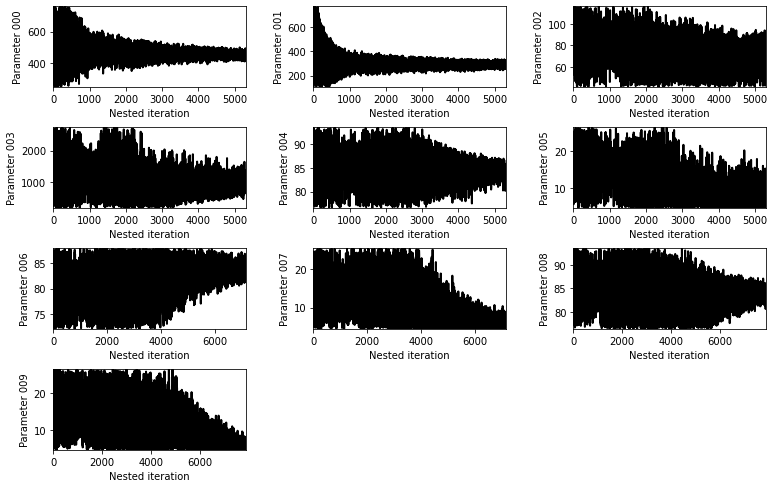

In [11]:
# Here you can see the evolution of the hyperparameters
# through the iterations for a given run
givenstar = '1717'
bg.parameter_evolution(prefix, givenstar, resultsubdir)

# Extra: How to make a summary directory

In [44]:
# Make a summary directory
# You can then run `pdfjam --fitpaper true --rotateoversize true *.pdf` and combine them
summarydir = 'summary_' + resultsubdir
summaryfile = 'summary_' + resultsubdir + '.csv'
if not os.path.exists(summarydir):
    print('Creates', summarydir)
    os.mkdir(summarydir)
for star in starlist:
    resultdir = os.path.join('./results/', prefix + star)
    for f in os.listdir(resultdir):
        if f.endswith('Background.pdf'):
            shutil.copy(os.path.join(resultdir, f), os.path.join(summarydir, f))
print('The total number of successes is', len(starlist))

# Make a summary file
allstars = np.sort(np.asarray(starlist + errorstars + skipstars))
success = np.isin(allstars, np.asarray(starlist))
errors = np.isin(allstars, np.asarray(errorstars))
skipped = np.isin(allstars, np.asarray(skipstars))

notecols = [nl for nl in numaxlist.columns if 'notes' in nl]
notes = []
for star in allstars:
    starmask = (numaxlist['star'] == prefix + str(star))
    for ncol in notecols:
        note = numaxlist[ncol][starmask].values
        if not pd.isnull(note):
            notes.append(star)

noted = np.isin(allstars, np.asarray(notes))

df = pd.DataFrame({'star': allstars,
                   'success': success,
                   'error': errors,
                   'skipped': skipped,
                   'noted': noted})
df.to_csv(summaryfile)

The total number of successes is 25
